In [83]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import igraph as ig
from itertools import combinations
import operator
import math
from tqdm import tqdm

# Question 3.1: parse the files
df_small = pd.read_csv(r'D:\Facultate\Year 2\Semester 1\Social Network Analysis for CS\assignment 2/twitter-small.tsv', 
                 sep='\t', header=None, names = ["timestamp", "user", "tweet"])
df_larger = pd.read_csv(r'D:\Facultate\Year 2\Semester 1\Social Network Analysis for CS\assignment 2/twitter-larger.tsv', 
                 sep='\t', header=None, names = ["timestamp", "user", "tweet"])


def extract_metions(text):
    mentions = []
    for word in text.split():
        if "@" in word:
            mentions.append(word.replace("@", "").replace(":", ""))
            
    if mentions == []:
        mentions.append("0")
            
    return mentions

def get_edgelist(df):
    sources = []
    targets = []
    timestamps = []
    
    for i in df.index:    
        text = df.loc[i, "tweet"]
        user = df.loc[i, "user"]
        timestamp = df.loc[i, "timestamp"]

        mentions = extract_metions(text)
        
        if mentions != ["0"]:
            for target in mentions:
                sources.append(user)
                targets.append(target)
                timestamps.append(timestamp)
                
    df_edgelist = pd.DataFrame()
    
    df_edgelist["source"] = sources
    df_edgelist["target"] = targets
    df_edgelist["timestamp"] = timestamps
    
    return df_edgelist

edgelist_small = get_edgelist(df_small)
edgelist_large = get_edgelist(df_larger)

# save files to csv
edgelist_small.to_csv(r'D:\Facultate\Year 2\Semester 1\Social Network Analysis for CS\assignment 2/edgelist_small.csv', index=False)
edgelist_large.to_csv(r'D:\Facultate\Year 2\Semester 1\Social Network Analysis for CS\assignment 2/edgelist_large.csv', index=False)

In [2]:
# Question 3.2: Extract statistics
# read the files after parsing
df_small = pd.read_csv(r'D:\Facultate\Year 2\Semester 1\Social Network Analysis for CS\assignment 2/edgelist_small.csv')
df_larger = pd.read_csv(r'D:\Facultate\Year 2\Semester 1\Social Network Analysis for CS\assignment 2/edgelist_large.csv')

In [3]:
# create the graphs from the dataframes
g_med = nx.from_pandas_edgelist(df_small, "source", "target", ['timestamp'], create_using = nx.DiGraph)
g_larger = nx.from_pandas_edgelist(df_larger, "source", "target", ['timestamp'], create_using = nx.DiGraph) 

In [304]:
def get_graph_statistics(g):
    n_nodes = g.number_of_nodes()
    n_edges = len(list(g.edges()))
    density = nx.density(g)
    avg_clustering = nx.average_clustering(g)
    n_scc = nx.number_strongly_connected_components(g)
    size_largest_scc = [len(c) for c in sorted(nx.strongly_connected_components(g), key=len, reverse=True)][0]
    
    n_wcc = nx.number_weakly_connected_components(g)
    size_largest_wcc = [len(c) for c in sorted(nx.weakly_connected_components(g), key=len, reverse=True)][0]
    
    stats = pd.DataFrame()
    stats["name"] = ["n_nodes", "n_edges","n_scc", "size_largest_scc","n_wcc","size_largest_wcc","density","avg_clustering"]
    stats["values"] = [n_nodes, n_edges, n_scc, size_largest_scc, n_wcc, size_largest_wcc, density, avg_clustering]
    
    return stats
    
stats_gmed = get_graph_statistics(g_med)
stats_glarger = get_graph_statistics(g_larger)

In [305]:
print("\033[1mStatistics for Medium Twitter Graph\033[0m")
print(stats_gmed.to_latex())
print('\n')
print("\033[1mStatistics for Larger Twitter Graph\033[0m")
print(stats_glarger.to_latex())

Statistics for Medium Twitter Graph
\begin{tabular}{llr}
\toprule
{} &              name &        values \\
\midrule
0 &           n\_nodes &  68832.000000 \\
1 &           n\_edges &  69917.000000 \\
2 &             n\_scc &  68534.000000 \\
3 &  size\_largest\_scc &     22.000000 \\
4 &             n\_wcc &  11858.000000 \\
5 &  size\_largest\_wcc &  40399.000000 \\
6 &           density &      0.000015 \\
7 &    avg\_clustering &      0.015687 \\
\bottomrule
\end{tabular}



Statistics for Larger Twitter Graph
\begin{tabular}{llr}
\toprule
{} &              name &        values \\
\midrule
0 &           n\_nodes &  6.948640e+05 \\
1 &           n\_edges &  1.050393e+06 \\
2 &             n\_scc &  6.617280e+05 \\
3 &  size\_largest\_scc &  2.811200e+04 \\
4 &             n\_wcc &  7.091000e+04 \\
5 &  size\_largest\_wcc &  5.294960e+05 \\
6 &           density &  2.175469e-06 \\
7 &    avg\_clustering &  2.062244e-02 \\
\bottomrule
\end{tabular}



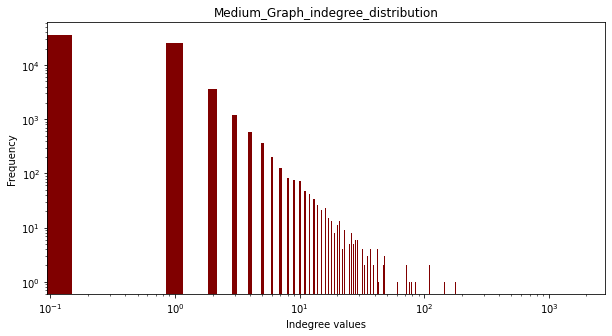

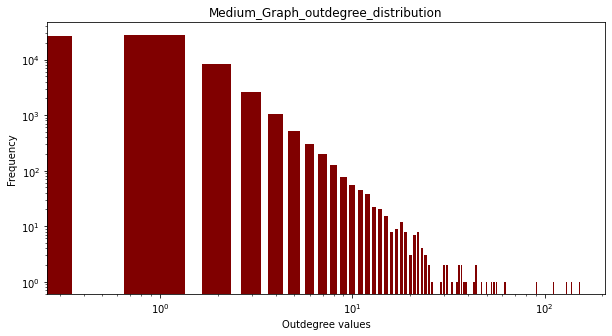

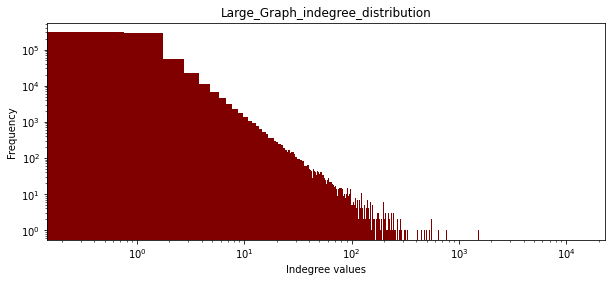

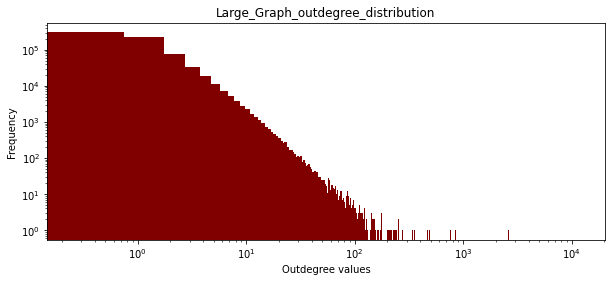

In [306]:
def get_indegree_distribution(G):
    histogram = {}
    for node, in_degree_value in G.in_degree():
        if in_degree_value not in histogram.keys():
            histogram[in_degree_value] = 1
        else:
            histogram[in_degree_value] += 1
        
    return histogram

def get_outdegree_distribution(G):
    histogram_outdegree = {}
    for node, out_degree_value in G.out_degree():
        if out_degree_value not in histogram_outdegree.keys():
            histogram_outdegree[out_degree_value] = 1
        else:
            histogram_outdegree[out_degree_value] += 1
        
    return histogram_outdegree


indegree_distribution_g_med = dict(sorted(get_indegree_distribution(g_med).items()))
indegree_distribution_g_larger = dict(sorted(get_indegree_distribution(g_larger).items()))

outdegree_distribution_g_med = dict(sorted(get_outdegree_distribution(g_med).items()))
outdegree_distribution_g_larger = dict(sorted(get_outdegree_distribution(g_larger).items()))


def plot_histogram(histogram_dict, size, w, title, x_title, plot_type = "normal"):
    x_label = list(histogram_dict.keys())
    y_label = list(histogram_dict.values())
    
    fig = plt.figure(figsize = size)
    
#     plt.plot(x_label, y_label, color ='red')
    
    plt.bar(x_label, y_label, color ='maroon', width = w)
    
    if plot_type == 'log-log':
        plt.yscale('log')
        plt.xscale('log')
    elif plot_type == 'log-y':
        plt.yscale('log')
        
    elif plot_type == 'log-x':
        plt.xscale('log')
    
    plt.xlabel(x_title)
    plt.ylabel("Frequency")
    plt.title(title)
    
    save_path = "A2_" + title + ".png"
    
    plt.savefig(save_path)

# obtain the figures
# For the Medium size graph
figg = plot_histogram(indegree_distribution_g_med, (10,5), 0.3, "Medium_Graph_indegree_distribution", "Indegree values", "log-log")
figg = plot_histogram(outdegree_distribution_g_med, (10,5), 0.7, "Medium_Graph_outdegree_distribution", "Outdegree values", "log-log")

# For the Large size graph
figg = plot_histogram(indegree_distribution_g_larger, (10,4),  1.5, "Large_Graph_indegree_distribution", "Indegree values", "log-log")
figg = plot_histogram(outdegree_distribution_g_larger, (10,4),  1.5, "Large_Graph_outdegree_distribution", "Outdegree values", "log-log")

In [4]:
# get the distance distribution of the giant component (largest weakly connected component)
def get_n_edges_in_component(G, node_list):
    G_edge_list = list(G.edges())
    
    filtered_edges = list(filter(lambda edge: (edge[0] in node_list and edge[1] in node_list), G_edge_list))
    
    return filtered_edges

largest_weakly_g_med = max(nx.weakly_connected_components(g_med), key=len)
wcc_g_med_edges = get_n_edges_in_component(g_med, largest_weakly_g_med)

# Create a new graph from the edges of the wcc obtained 
g_med_wcc = nx.Graph()
g_med_wcc.add_edges_from(wcc_g_med_edges)

In [12]:
# DISTANCE DISTRIBUTIONS
# The problem with these datasets is that they are large, which means that simply computing
# the all-pairs-shortest-paths lengths is computationally expensive.
# For this, 2 options were explored

##### Trial 1: Use A*, landmarks and triangle identities
# A total of 50 landmarks will be chosen according to their degree (highest) and used
nodes = np.array(g_med_wcc.nodes())
landmarks = []

for (user, degree) in sorted(g_med_wcc.degree, key=lambda x: x[1], reverse=True)[:100]:
        landmarks.append(user)
    
landmarks.remove(np.nan)
landmarks = landmarks[:50]

landmarks_ids = []

for user in landmarks:
    landmarks_ids.append(np.where(nodes == user)[0][0])
    
landmarks_ids = np.array(landmarks_ids)

# easiest way to map the nodes from string names to int values
# first get the adjacency matrix
adj_med = nx.adjacency_matrix(g_med_wcc)

# get the graph
wcc_med_int = nx.from_scipy_sparse_matrix(adj_med)

# the networkx.astar_path_length() with a heuristic will be used
# for the heuristic, the distance between all points to each landmark is first computed

heuristic_embedding = np.zeros((len(nodes), len(landmarks_ids)))

for lmark in landmarks_ids:
    sp_dict = nx.single_source_shortest_path_length(wcc_med_int, lmark)

    for target, length  in sp_dict.items():
        heuristic_embedding[target][np.where(landmarks_ids == lmark)[0][0]] = length
        
# variable heuristic_embedding is a numpy array where:
# - each row corresponds to a node in the graph
# - each column corresponds to a landmark (order of columns is the order of landmarks in landmarks_ids)
# - the distance is approximated by the upper bound, i.e. the min value of:
#        dist(source, landmark) + dist(landmark, target)

# estimate the distance between points as the upper bound of the triangle inequality
def heuristic_function(source, target): 
    
    return (heuristic_embedding[source] + heuristic_embedding[target]).min() 

In [13]:
%%timeit
# get the estimate duration for a single pair (source, target) using the A*, landmarks approach
nx.astar_path_length(wcc_med_int, 0, 522, heuristic=heuristic_function)

499 ms ± 35.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
# compare the above result to the simple A* algorithm
nx.astar_path_length(wcc_med_int, 0, 522)

253 ms ± 23.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
# get the estimate duration for a single pair (source, target) using Dijkstra's alg. 
nx.shortest_path_length(wcc_med_int, 0, 522)

250 µs ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [207]:
# get the estimate duration for a single pair (source, target) using the A*
%%timeit
nx.astar_path_length(wcc_med_int, 0, 522)

264 ms ± 7.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
# Clearly the A* + landmarks approach takes much more time than nx.shortest_path_length(), which is unfortunate
# maybe there is a way to properly and successfully implement this approach but due to time constraints
# no further efforts will be made in this direction

##### Trial 2: compute the distance distribution for a subset of the initial dataset

# select uniformly at random 2500 nodes from the subset and use them to compute shortest paths

n_usable_med = []
for i in np.random.randint(len(g_med_wcc.nodes()), size=2500):
    n_usable_med.append(list(g_med_wcc.nodes())[i])

In [36]:
# get all pairs of points
all_pairs_med = list(combinations(n_usable_med, 2))

distances_med = []
for (source,target) in tqdm(all_pairs_med):
#     d = nx.astar_path_length(wcc_med_int, source, target, heuristic=heuristic_function)
    d = nx.shortest_path_length(g_med_wcc, source, target)
    distances_med.append(d)

100%|██████████| 3123750/3123750 [13:31<00:00, 3849.87it/s]


In [37]:
df = pd.DataFrame()
df['distances'] = distances_med

distance_distrib = {}
for key in df.value_counts().index:
    freq = df.value_counts()[key]
    dist = key[0]
    distance_distrib[dist] = freq

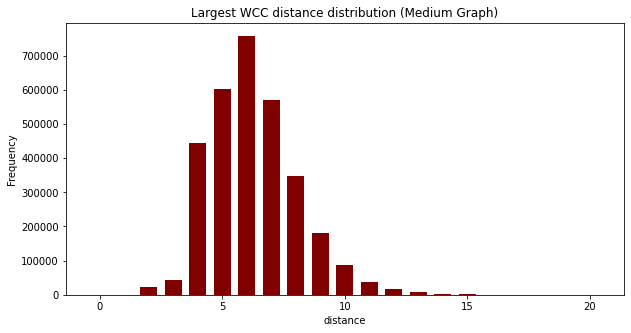

In [43]:
figg = plot_histogram(distance_distrib, (10,5), 0.7, "Largest WCC distance distribution (Medium Graph)", "distance")

In [41]:
# repeat for the larger graph
largest_weakly_g_larger = max(nx.weakly_connected_components(g_larger), key=len)
wcc_g_larger_edges = get_n_edges_in_component(g_larger, largest_weakly_g_larger)

# Create a new graph from the edges of the wcc obtained 
g_larger_wcc = nx.Graph()
g_larger_wcc.add_edges_from(wcc_g_larger_edges)

In [42]:
n_usable_large = []
for i in np.random.randint(len(g_larger_wcc.nodes()), size=2500):
    n_usable_large.append(list(g_larger_wcc.nodes())[i])

In [44]:
# get all pairs of points
all_pairs_large = list(combinations(n_usable_large, 2))

distances_large = []
for (source,target) in tqdm(all_pairs_large):
#     d = nx.astar_path_length(wcc_med_int, source, target, heuristic=heuristic_function)
    d = nx.shortest_path_length(g_larger_wcc, source, target)
    distances_large.append(d)
    
df_lwcc = pd.DataFrame()
df_lwcc['distances'] = distances_large

distance_distrib_large = {}
for key in df_lwcc.value_counts().index:
    freq = df_lwcc.value_counts()[key]
    dist = key[0]
    distance_distrib_large[dist] = freq

100%|██████████| 3123750/3123750 [42:00<00:00, 1239.27it/s] 


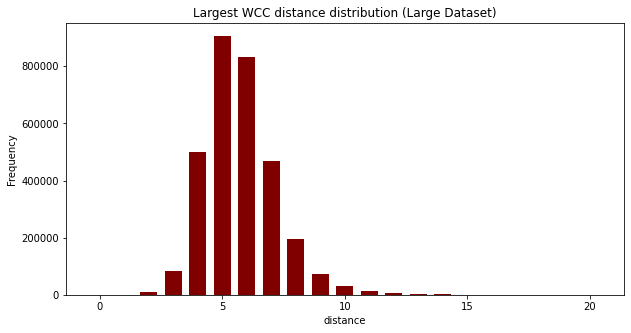

In [46]:
figg = plot_histogram(distance_distrib_large, (10,5), 0.7, "Largest WCC distance distribution (Large Dataset)", "distance")

In [14]:
# Question 3.3: eigenvector, degree and PageRank centrality

## For Degree centrality, in-degree/out-degree will be used since the graph is directed
# In-Degree Centrality
in_degr_c_med = nx.in_degree_centrality(g_med)
in_degr_c_large = nx.in_degree_centrality(g_larger)

top20_in_degr_med = list(dict(sorted(in_degr_c_med.items(), key=operator.itemgetter(1),reverse=True)))[:20]
top20_in_degr_large = list(dict(sorted(in_degr_c_large.items(), key=operator.itemgetter(1),reverse=True)))[:20]

# Out-Degree Centrality
out_degr_c_med = nx.out_degree_centrality(g_med)
out_degr_c_large = nx.out_degree_centrality(g_larger)

top20_out_degr_med = list(dict(sorted(out_degr_c_med.items(), key=operator.itemgetter(1),reverse=True)))[:20]
top20_out_degr_large = list(dict(sorted(out_degr_c_large.items(), key=operator.itemgetter(1),reverse=True)))[:20]

In [15]:
# PageRank is designed for directed graphs, therefore directionality is not an issue
# PageRank centrality
pagerank_c_med = nx.pagerank(g_med)
pagerank_c_large = nx.pagerank(g_larger)

top20_pagerank_med = list(dict(sorted(pagerank_c_med.items(), key=operator.itemgetter(1),reverse=True)))[:20]
top20_pagerank_large = list(dict(sorted(pagerank_c_large.items(), key=operator.itemgetter(1),reverse=True)))[:20]

In [16]:
# To compute eigenvector centrality for a directed graph, similarly to the degree centrality,
# in-eigenvector-centrality and out-eigenvector-centrality will be computed

# IN - Eigenvector centrality
in_egn_c_med = nx.eigenvector_centrality_numpy(g_med)
in_egn_c_large = nx.eigenvector_centrality_numpy(g_larger)

top20_in_egn_med = list(dict(sorted(in_egn_c_med.items(), key=operator.itemgetter(1),reverse=True)))[:20]
top20_in_egn_large = list(dict(sorted(in_egn_c_large.items(), key=operator.itemgetter(1),reverse=True)))[:20]

# OUT - Eigenvector Centrality
out_egn_c_med = nx.eigenvector_centrality_numpy(g_med.reverse())
out_egn_c_large = nx.eigenvector_centrality_numpy(g_larger.reverse())

top20_out_egn_med = list(dict(sorted(out_egn_c_med.items(), key=operator.itemgetter(1),reverse=True)))[:20]
top20_out_egn_large = list(dict(sorted(out_egn_c_med.items(), key=operator.itemgetter(1),reverse=True)))[:20]

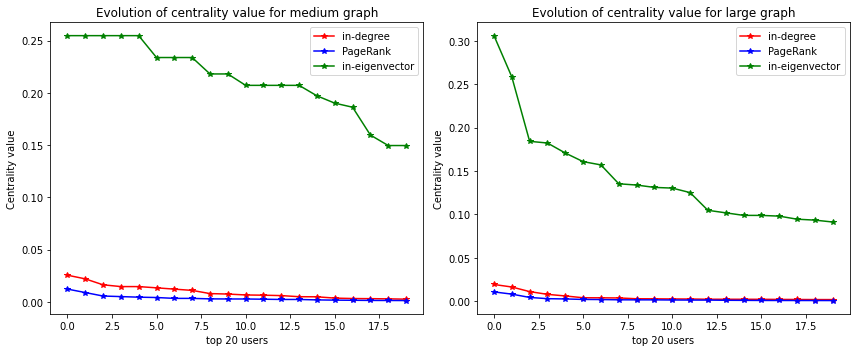

In [55]:
y1_1 = list(dict(sorted(in_degr_c_med.items(), key=operator.itemgetter(1),reverse=True)).values())[:20]
y2_1 = list(dict(sorted(pagerank_c_med.items(), key=operator.itemgetter(1),reverse=True)).values())[:20]
y3_1 = list(dict(sorted(in_egn_c_med.items(), key=operator.itemgetter(1),reverse=True)).values())[:20]
x_range = list(range(20))

fig, ax = plt.subplots(1,2,figsize = (12,5))
ax[0].plot(x_range, y1_1, color ='red', label = "in-degree", marker='*')
ax[0].plot(x_range, y2_1, color ='blue', label = "PageRank", marker='*')
ax[0].plot(x_range, y3_1, color ='green', label = "in-eigenvector", marker='*')
ax[0].legend()
ax[0].set_ylabel("Centrality value")
ax[0].set_xlabel("top 20 users")
ax[0].set_title("Evolution of centrality value for medium graph")

y1_2 = list(dict(sorted(in_degr_c_large.items(), key=operator.itemgetter(1),reverse=True)).values())[:20]
y2_2 = list(dict(sorted(pagerank_c_large.items(), key=operator.itemgetter(1),reverse=True)).values())[:20]
y3_2 = list(dict(sorted(in_egn_c_large.items(), key=operator.itemgetter(1),reverse=True)).values())[:20]

ax[1].plot(x_range, y1_2, color ='red', label = "in-degree", marker='*')
ax[1].plot(x_range, y2_2, color ='blue', label = "PageRank", marker='*')
ax[1].plot(x_range, y3_2, color ='green', label = "in-eigenvector", marker='*')
ax[1].legend()
ax[1].set_ylabel("Centrality value")
ax[1].set_xlabel("top 20 users")
ax[1].set_title("Evolution of centrality value for large graph")

plt.tight_layout()
# plt.show()

save_path = "./A2_Q3.2_centrality_values.jpg"    
plt.savefig(save_path)

In [31]:
df_common_med = pd.DataFrame()
df_common_med["x"] = ["In-degree", "PageRank", "In-eigenvector"]
df_common_med["In-degree"] = [20, len(list(set(top20_in_degr_med).intersection(top20_pagerank_med))),
                             len(list(set(top20_in_degr_med).intersection(top20_in_egn_med)))]

df_common_med["PageRank"] = [len(list(set(top20_pagerank_med).intersection(top20_in_degr_med))), 20,
                             len(list(set(top20_pagerank_med).intersection(top20_in_egn_med)))]

df_common_med["In-eigenvector"] = [len(list(set(top20_in_egn_med).intersection(top20_in_degr_med))),
                             len(list(set(top20_in_egn_med).intersection(top20_pagerank_med))), 20]

df_common_large = pd.DataFrame()
df_common_large["x"] = ["In-degree", "PageRank", "In-eigenvector"]
df_common_large["In-degree"] = [20, len(list(set(top20_in_degr_large).intersection(top20_pagerank_large))),
                             len(list(set(top20_in_degr_large).intersection(top20_in_egn_large)))]

df_common_large["PageRank"] = [len(list(set(top20_pagerank_large).intersection(top20_in_degr_large))), 20,
                             len(list(set(top20_pagerank_large).intersection(top20_in_egn_large)))]

df_common_large["In-eigenvector"] = [len(list(set(top20_in_egn_large).intersection(top20_in_degr_large))),
                             len(list(set(top20_in_egn_large).intersection(top20_pagerank_large))), 20]


print("\033[1mNumber of common users found accross the centrality measures for medium graph\033[0m")
print(df_common_med.to_latex())
print('\n')
print("\033[1mNumber of common users found accross the centrality measures for large graph\033[0m")
print(df_common_large.to_latex())

Number of common users found accross the centrality measures for medium graph
\begin{tabular}{llrrr}
\toprule
{} &               x &  In-degree &  PageRank &  In-eigenvector \\
\midrule
0 &       In-degree &         20 &        17 &               1 \\
1 &        PageRank &         17 &        20 &               1 \\
2 &  In-eigenvector &          1 &         1 &              20 \\
\bottomrule
\end{tabular}



Number of common users found accross the centrality measures for large graph
\begin{tabular}{llrrr}
\toprule
{} &               x &  In-degree &  PageRank &  In-eigenvector \\
\midrule
0 &       In-degree &         20 &        15 &               1 \\
1 &        PageRank &         15 &        20 &               0 \\
2 &  In-eigenvector &          1 &         0 &              20 \\
\bottomrule
\end{tabular}



In [216]:
# Question 3.4: Community detection
# get giant component
largest_weakly_g_med = max(nx.weakly_connected_components(g_med), key=len)
edge_list = list(g_med.edges())

filtered_edges = list(filter(lambda edge: (edge[0] in largest_weakly_g_med and edge[1] in largest_weakly_g_med), edge_list))

for i in range(len(filtered_edges)):
    edge = filtered_edges[i]
    
    timestamp = g_med.get_edge_data(*edge)
    filtered_edges[i] = filtered_edges[i] + (timestamp,)

# Create a new graph from the edges of the wcc obtained 
g_med_wcc = nx.Graph()
g_med_wcc.add_edges_from(filtered_edges)

In [78]:
# save the graph locally
g_med_wcc_int = nx.convert_node_labels_to_integers(g_med_wcc)
df_giant_component = nx.to_pandas_edgelist(g_med_wcc_int)
df_giant_component.to_csv(r"D:\Facultate\Year 2\Semester 1\Social Network Analysis for CS\assignment 2/giant_component.csv", header=False, index=False)

In [102]:
from networkx.algorithms.community import  greedy_modularity_communities, modularity

# get communities based on modularity
modularity_community = greedy_modularity_communities(g_med_wcc)
# get modularity value
modularity_val = modularity(g_med_wcc, modularity_community)

In [147]:
df_giant_component_labels = nx.to_pandas_edgelist(g_med_wcc)

edges_within_community = []
for i in range(len(modularity_community)):
    community = modularity_community[i]
    
    n_edges = len(df_giant_component_labels[(df_giant_component_labels.source.isin(community)) & (df_giant_component_labels.target.isin(community))])
    edges_within_community.append(n_edges)
    
community_size = [len(c) for c in modularity_community]

In [148]:
# get edges outside the community
edges_oustide_community = []
for i in tqdm(range(len(modularity_community))):
    community = modularity_community[i]
    
    edges_outside = 0
    for node in community: 
        edges_outside += len(df_giant_component_labels[(df_giant_component_labels.source == node) & (~df_giant_component_labels.target.isin(community))])
    
    edges_oustide_community.append(edges_outside)

100%|██████████| 161/161 [04:42<00:00,  1.75s/it]


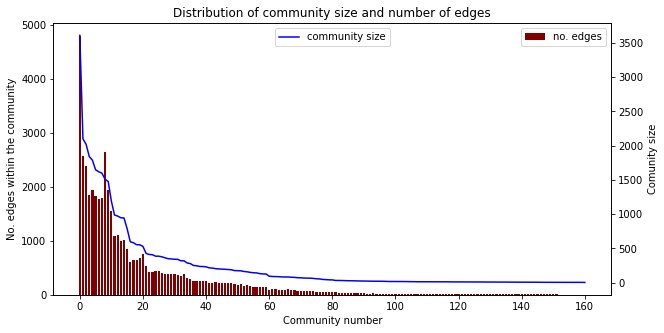

In [138]:
fig, ax1 = plt.subplots(figsize = (10, 5))

ax2 = ax1.twinx()
# creating the bar plot
ax1.bar(list(range(len(edges_within_community))), edges_within_community, color ='maroon',
        width = 0.7, label = 'no. edges')
 
ax1.set_xlabel("Community number")
ax1.set_ylabel("No. edges within the community")
ax1.set_title("Distribution of community size and number of edges")
ax1.legend(loc='upper right')

ax2.plot(list(range(len(edges_within_community))), community_size, color='blue', label = 'community size')
ax2.legend(loc='upper center')
ax2.set_ylabel("Comunity size")
# plt.show()

save_path = "./A2_Q3.4_distribution.png"    
plt.savefig(save_path)

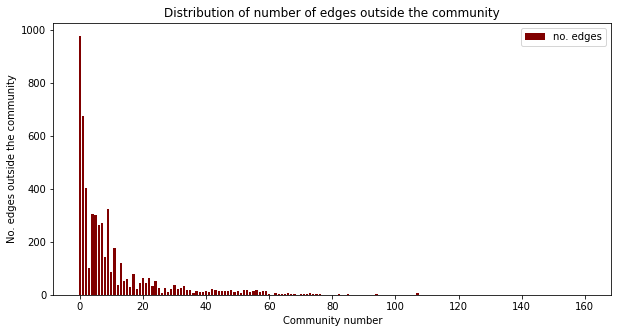

In [151]:
fig, ax1 = plt.subplots(figsize = (10, 5))

# creating the bar plot
ax1.bar(list(range(len(edges_oustide_community))), edges_oustide_community, color ='maroon',
        width = 0.7, label = 'no. edges')
 
ax1.set_xlabel("Community number")
ax1.set_ylabel("No. edges outside the community")
ax1.set_title("Distribution of number of edges outside the community")
ax1.legend(loc='upper right')

save_path = "./A2_Q3.4_distribution2.png"    
plt.savefig(save_path)

In [140]:
print(f"Modularity value of the giant component is: {modularity_val}")

Modularity value of the giant component is: 0.8594358644280689
